In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from scipy.sparse import coo_matrix

# Bureau

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

In [ ]:
bureau = pd.read_csv('C:\\Users\\maria\\Desktop\\Uni\\S2\\Machine Learning\\Group Project\\data\\bureau.csv')
#bureau = pd.read_csv('../all/bureau.csv')

In [ ]:
bureau.shape

In [ ]:
bureau.head()

In [ ]:
#number of unique SK_ID_CURR
len(bureau['SK_ID_CURR'].unique())

In [ ]:
bureau.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count().sort_values(ascending=False)

In [ ]:
variables_type = pd.DataFrame(bureau.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in bureau:
    if ((list(bureau[i].unique()) == [0,1]) or (list(bureau[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_BUREAU"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

In [ ]:
for column in cat_variables:
    print(column)
    print(bureau[column].unique())
    print('--------------------------')

**Duplicates**

In [ ]:
#check duplicates
duplicate_rows = bureau[bureau.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

**Missing Values**

In [ ]:
#List the variables with missing values higher or equal to 40% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
miss_higher40 = []

for i in bureau:
    pct_missing = (bureau[i].isna().sum()/len(bureau[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [ ]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [ ]:
bureau[num_variables].describe()

In [ ]:
bureau[num_variables].hist(bins=50, figsize=(20,15))
plt.show()

Findings:

* "DAYS(...)" variables are counter-intuitively negative

In [ ]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in bureau.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

## Pipeline

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, bureau, y=None):
        return self
    
    def transform(self, bank):
        return bureau[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

In [ ]:
def negative_to_positive(columns):
    for i in columns:
        bureau[i] = abs(bureau[i])

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ])

day_col_pipeline = Pipeline([
        ('neg_to_pos', negative_to_positive(day_variables)),
        ('selector', DataFrameSelector(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

In [ ]:
preprocess_pipeline.fit(bureau)

preprocessed_bureau = preprocess_pipeline.transform(bureau)

In [ ]:
num_feature_names = preprocess_pipeline.named_transformers_['num_pipeline'].named_steps['selector'].get_feature_names()
day_feature_names = preprocess_pipeline.named_transformers_['days_pipeline'].named_steps['selector'].get_feature_names()
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = num_feature_names + day_feature_names + cat_feature_names + cat_binary_variables

In [ ]:
transformed_bureau_df = pd.DataFrame(preprocessed_bureau, columns=feature_names)
transformed_bureau_df = pd.concat([bureau[["SK_ID_CURR", "SK_ID_BUREAU"]],transformed_bureau_df], axis=1)
transformed_bureau_df

## GroupBy

In [ ]:
grouped = transformed_bureau_df.groupby('SK_ID_CURR').agg(
    {'SK_ID_BUREAU': 'first',
    'CREDIT_DAY_OVERDUE': 'mean',
    'CNT_CREDIT_PROLONG': 'mean',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    #FAZ SENTIDO O SUM LIMIT TER VALORES NEGATIVOS E N PORMOS A 0 ESSES? A CENA DA MEDIANA NA IMPUTATION AQUI É MEIO ESTRANHO POSSO SER SO EU
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'mean',
    #NEGATIVOS??
    'DAYS_CREDIT': 'sum',
    #NEGATIVOS??
    'DAYS_CREDIT_ENDDATE': 'sum',
    #NEGATIVOS??
    'DAYS_ENDDATE_FACT': 'sum',
    #NEGATIVOS??
    'DAYS_CREDIT_UPDATE': 'sum',
    #SOMEI TODOS OS VALORES ONDE SE FAZIA O ENCODER
    'CREDIT_ACTIVE_Active': 'sum',
    'CREDIT_ACTIVE_Bad debt': 'sum',
    'CREDIT_ACTIVE_Closed': 'sum',
    'CREDIT_ACTIVE_Sold': 'sum',
    'CREDIT_CURRENCY_currency 1': 'sum',
    'CREDIT_CURRENCY_currency 2': 'sum',
    'CREDIT_CURRENCY_currency 3': 'sum',
    'CREDIT_CURRENCY_currency 4': 'sum',
    'CREDIT_TYPE_Another type of loan': 'sum',
    'CREDIT_TYPE_Car loan': 'sum',
    'CREDIT_TYPE_Cash loan (non-earmarked)': 'sum',
    'CREDIT_TYPE_Consumer credit': 'sum',
    'CREDIT_TYPE_Credit card': 'sum',
    'CREDIT_TYPE_Interbank credit': 'sum',
    'CREDIT_TYPE_Loan for business development': 'sum',
    'CREDIT_TYPE_Loan for purchase of shares (margin lending)': 'sum',
    'CREDIT_TYPE_Loan for the purchase of equipment': 'sum',
    'CREDIT_TYPE_Loan for working capital replenishment': 'sum',
    'CREDIT_TYPE_Microloan': 'sum',
    'CREDIT_TYPE_Mobile operator loan': 'sum',
    'CREDIT_TYPE_Mortgage': 'sum',
    'CREDIT_TYPE_Real estate loan': 'sum',
    'CREDIT_TYPE_Unknown type of loan': 'sum'
    })

grouped

# Bureau Balance

Monthly balances of previous credits in Credit Bureau.

In [32]:
bureau_balance = pd.read_csv('C:\\Users\\maria\\Desktop\\Uni\\S2\\Machine Learning\\Group Project\\data\\bureau_balance.csv')

In [4]:
bureau_balance.shape

(27299925, 3)

number of rows = # loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits

In [5]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [6]:
variables_type = pd.DataFrame(bureau_balance.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in bureau_balance:
    if ((list(bureau_balance[i].unique()) == [0,1]) or (list(bureau_balance[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_BUREAU"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE']


In [7]:
for column in cat_variables:
    print(column)
    print(bureau_balance[column].unique())

STATUS
['C' '0' 'X' '1' '2' '3' '5' '4']


* C - closed
* X - status unknown
* 0 - no DPD
* 1 - maximal did during month between 1-30
* 2 - DPD 31-60
* 5 - DPD 120+ or sold or written off

In [8]:
#replace x for NaN
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace('X', np.nan)

**Duplicates**

In [9]:
#check duplicates
duplicate_rows = bureau_balance[bureau_balance.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [10]:
#List the variables with missing values higher or equal to 40% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
miss_higher40 = []

for i in bureau_balance:
    pct_missing = (bureau_balance[i].isna().sum()/len(bureau_balance[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [11]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [12]:
bureau_balance[num_variables].describe()

,MONTHS_BALANCE
count,2.729992e+07
mean,-3.074169e+01
std,2.386451e+01
min,-9.600000e+01
25%,-4.600000e+01
50%,-2.500000e+01
75%,-1.100000e+01
max,0.000000e+00


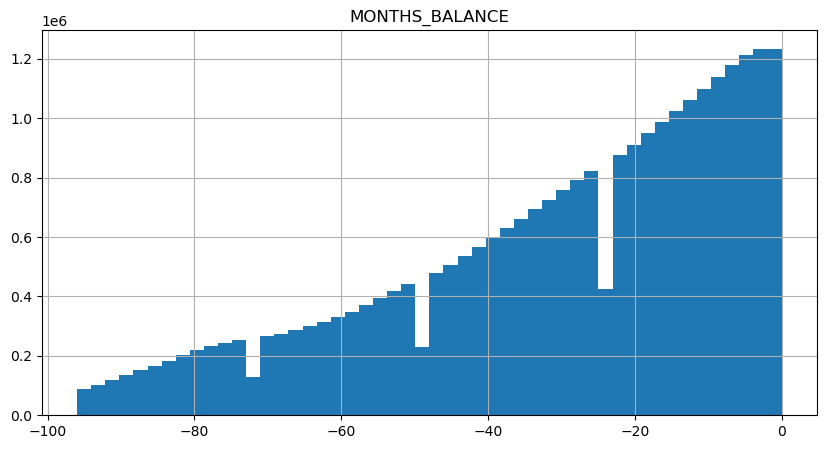

In [13]:
bureau_balance[num_variables].hist(bins=50, figsize=(10,5))
plt.show()

Month of balance relative to application date (-1 means the freshest balance date)

Findings:

* MONTHS_BALANCE variable is counter-intuitively negative 

## GroupBy

In [14]:
bureau_balance = bureau_balance.drop('MONTHS_BALANCE', axis=1)

In [15]:
num_variables.remove('MONTHS_BALANCE')

In [16]:
grouped = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].agg(lambda x: x.mode()[1] if len(x.mode()) > 1 and not x.mode()[0].startswith('X') else x.mode()[0] if len(x.mode()) > 0 and not x.mode()[0].startswith('X') else np.nan)

In [17]:
grouped = grouped.reset_index(name='STATUS')

In [18]:
grouped['STATUS'] = grouped['STATUS'].fillna(grouped['STATUS'].mode()[0])

In [34]:
bureau_balance = grouped

In [35]:
bureau_balance

,SK_ID_BUREAU,STATUS
0,5001709,C
1,5001710,C
2,5001711,0
3,5001712,0
4,5001713,C
...,...,...
817390,6842884,C
817391,6842885,5
817392,6842886,C
817393,6842887,C


## Pipeline

In [22]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, bureau_balance, y=None):
        return self
    
    def transform(self, bank):
        return bureau_balance[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

In [23]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("cat_pipeline", cat_pipeline, cat_variables)
])

In [24]:
preprocess_pipeline.fit(bureau_balance)

preprocessed_bureau_balance = preprocess_pipeline.transform(bureau_balance)

In [25]:
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = cat_feature_names + cat_binary_variables

C:\Users\maria\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [59]:
# Convert the sparse matrix to a coordinate format matrix
coo = coo_matrix(preprocessed_bureau_balance)

# Create a DataFrame from the coordinate format matrix
transformed_bureau_balance_df = pd.DataFrame({'row': coo.row, 'col': coo.col, 'val': coo.data}).pivot(columns='col', values='val').fillna(0).rename(columns=dict(enumerate(feature_names)))

In [60]:
transformed_bureau_balance_df = pd.concat([bureau_balance["SK_ID_BUREAU"],transformed_bureau_balance_df], axis=1)
transformed_bureau_balance_df

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C
0,5001709,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5001710,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5001711,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5001712,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5001713,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
817390,6842884,0.0,0.0,0.0,0.0,0.0,0.0,1.0
817391,6842885,0.0,0.0,0.0,0.0,0.0,1.0,0.0
817392,6842886,0.0,0.0,0.0,0.0,0.0,0.0,1.0
817393,6842887,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# POSH_CASH_balance

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

In [62]:
posh = pd.read_csv('C:\\Users\\maria\\Desktop\\Uni\\S2\\Machine Learning\\Group Project\\data\\POS_CASH_balance.csv')

In [63]:
posh.shape

(10001358, 8)

In [64]:
posh.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [65]:
variables_type = pd.DataFrame(posh.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in posh:
    if ((list(posh[i].unique()) == [0,1]) or (list(posh[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_PREV"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE', 'SK_DPD', 'SK_DPD_DEF', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']


In [66]:
for column in cat_variables:
    print(column)
    print(posh[column].unique())

NAME_CONTRACT_STATUS
['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']


Contract status during the month.

In [67]:
#replace XNA for NaN
posh['NAME_CONTRACT_STATUS'] = posh['NAME_CONTRACT_STATUS'].replace('XNA', np.nan)

**Duplicates**

In [74]:
#check duplicates
duplicate_rows = posh[posh.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [69]:
#List the variables with missing values higher or equal to 40% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
miss_higher40 = []

for i in posh:
    pct_missing = (posh[i].isna().sum()/len(posh[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [70]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [75]:
posh[num_variables].describe()

,MONTHS_BALANCE,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06
mean,-3.501259e+01,1.160693e+01,6.544684e-01,1.708965e+01,1.048384e+01
std,2.606657e+01,1.327140e+02,3.276249e+01,1.199506e+01,1.110906e+01
min,-9.600000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,-5.400000e+01,0.000000e+00,0.000000e+00,1.000000e+01,3.000000e+00
50%,-2.800000e+01,0.000000e+00,0.000000e+00,1.200000e+01,7.000000e+00
75%,-1.300000e+01,0.000000e+00,0.000000e+00,2.400000e+01,1.400000e+01
max,-1.000000e+00,4.231000e+03,3.595000e+03,9.200000e+01,8.500000e+01


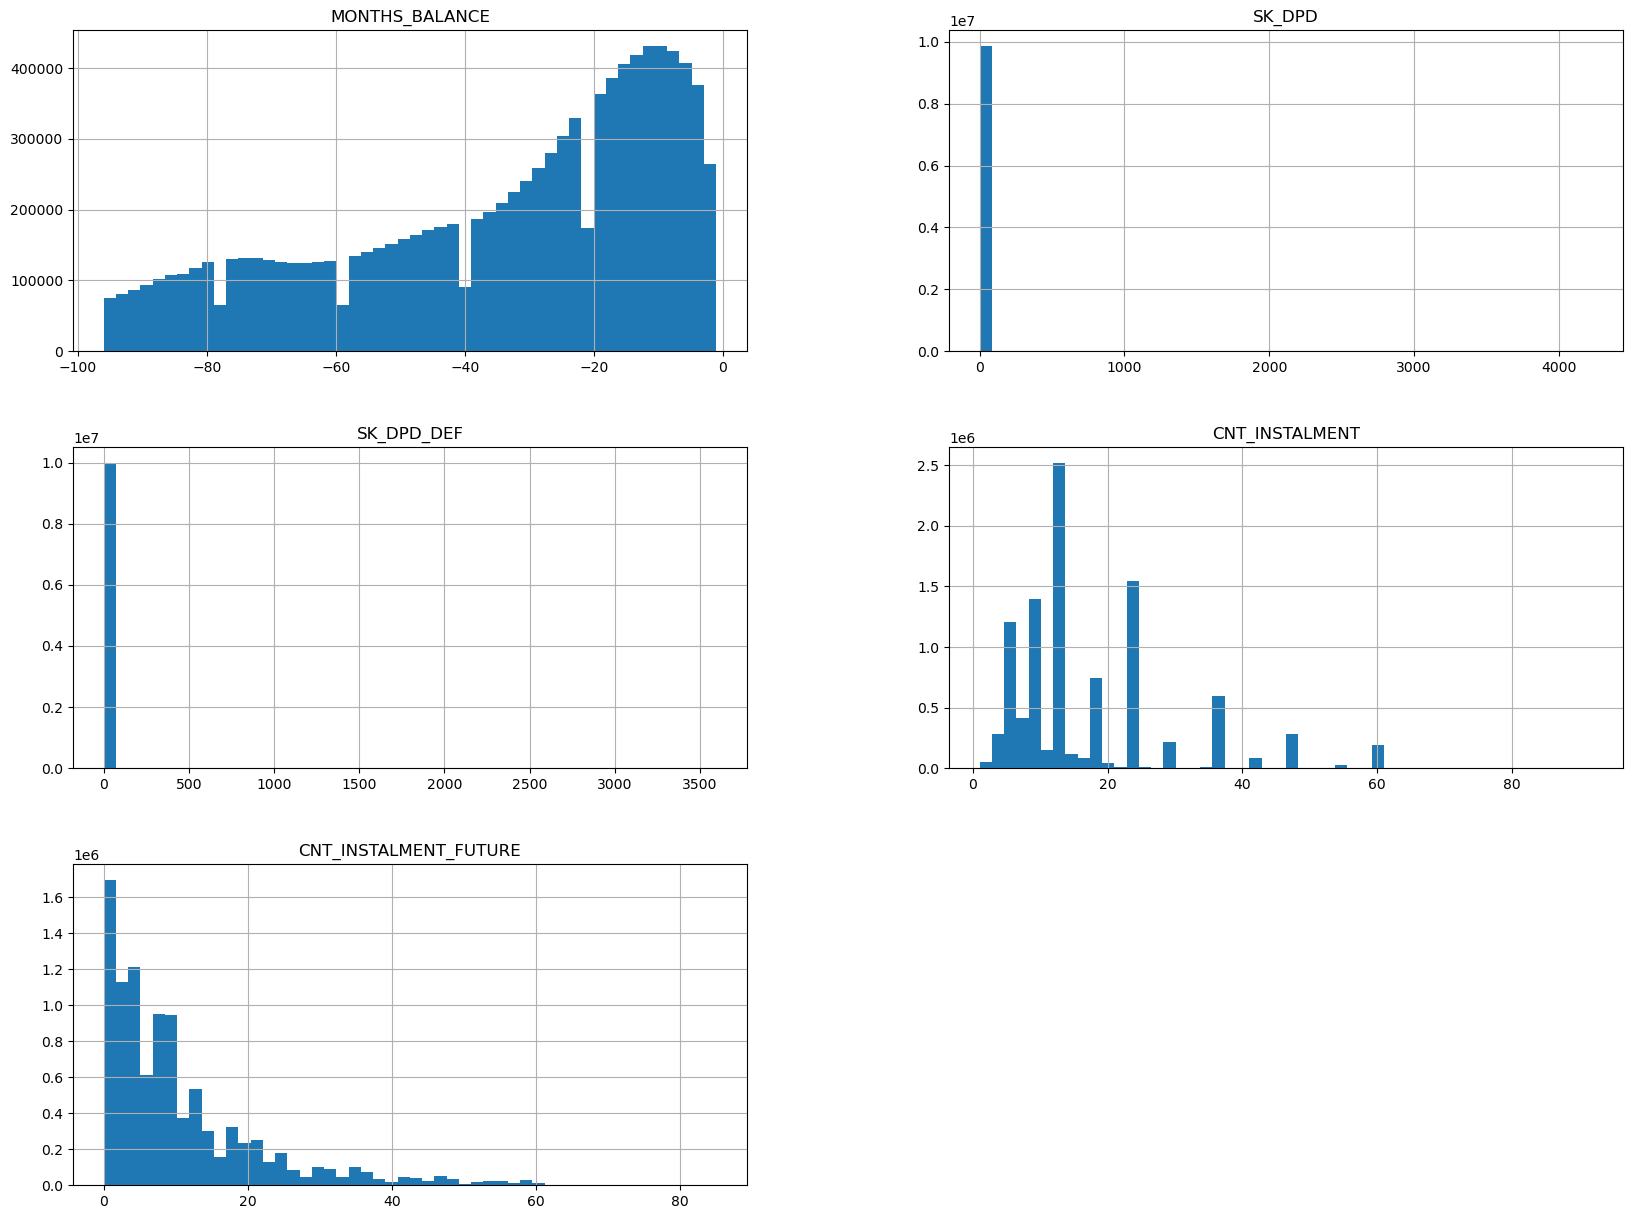

In [76]:
posh[num_variables].hist(bins=50, figsize=(20,15))
plt.show()

Findings:

* MONTHS_BALANCE - Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly)

* SK_DPD - DPD (days past due) during the month of previous credit

* SK_DPD_DEF - DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

* CNT_INSTALMENT - Term of previous credit (can change over time)

* CNT_INSTALMENT_FUTURE - Installments left to pay on the previous credit

MONTHS_BALANCE is not important.

In [82]:
posh = posh.drop('MONTHS_BALANCE', axis=1)

In [89]:
num_variables.remove('MONTHS_BALANCE')

## Pipeline

In [90]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, posh, y=None):
        return self
    
    def transform(self, bank):
        return posh[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

In [95]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median"))
        ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

In [96]:
preprocess_pipeline.fit(posh)

preprocessed_posh = preprocess_pipeline.transform(posh)

In [97]:
num_feature_names = preprocess_pipeline.named_transformers_['num_pipeline'].named_steps['selector'].get_feature_names()
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = num_feature_names + cat_feature_names + cat_binary_variables

C:\Users\maria\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
transformed_posh_df = pd.DataFrame(preprocessed_posh, columns=feature_names)
transformed_posh_df = pd.concat([posh[["SK_ID_PREV", "SK_ID_CURR"]],transformed_posh_df], axis=1)
transformed_posh_df

,SK_ID_PREV,SK_ID_CURR,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed
0,1803195,182943,0.0,0.0,48.0,45.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1715348,367990,0.0,0.0,36.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1784872,397406,0.0,0.0,12.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1903291,269225,0.0,0.0,48.0,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2341044,334279,0.0,0.0,36.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,843.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001354,1717234,141565,602.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001355,1283126,315695,609.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001356,1082516,450255,614.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## GroupBy

In [101]:
grouped = transformed_posh_df.groupby('SK_ID_CURR').agg(
    {'SK_ID_PREV': 'first',
    'SK_DPD': 'mean', 
    'SK_DPD_DEF': 'mean', 
    'CNT_INSTALMENT': 'mean',
    'CNT_INSTALMENT_FUTURE': 'mean',

    'NAME_CONTRACT_STATUS_Active': 'sum', 
    'NAME_CONTRACT_STATUS_Amortized debt': 'sum',
    'NAME_CONTRACT_STATUS_Approved': 'sum', 
    'NAME_CONTRACT_STATUS_Canceled': 'sum',
    'NAME_CONTRACT_STATUS_Completed': 'sum', 
    'NAME_CONTRACT_STATUS_Demand': 'sum',
    'NAME_CONTRACT_STATUS_Returned to the store': 'sum',
    'NAME_CONTRACT_STATUS_Signed': 'sum'
    })

grouped

,SK_ID_PREV,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed
SK_ID_CURR,,,,,,,,,,,,,
100001,1851984,0.777778,0.777778,4.000000,1.444444,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
100002,1038818,0.000000,0.000000,24.000000,15.000000,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,2396755,0.000000,0.000000,10.107143,5.785714,26.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
100004,1564014,0.000000,0.000000,3.750000,2.250000,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100005,2495675,0.000000,0.000000,11.727273,7.181818,9.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,2248017,0.000000,0.000000,8.333333,4.666667,7.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
456252,1503599,0.000000,0.000000,6.000000,3.000000,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
456253,1686207,0.294118,0.294118,6.705882,2.000000,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
